## German Credit Data
#### Andrea Sabia

In [1]:
# Importing needed packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

In [2]:
#Setting working directory
os.chdir("/Users/andreasabia/Documents/ESCP/Analytical Modeling")
#Importing dataset
df=pd.read_csv("./data for problem B.csv")

#### Exploring dataset

In [3]:
df.describe()

,Default,duration,amount,installment,residence,age,cards,liable
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,0.300000,20.732222,3268.436667,2.965556,2.866667,35.622222,1.412222,1.155556
std,0.458512,11.790178,2839.812099,1.116133,1.102127,11.429309,0.575806,0.362635
min,0.000000,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,0.000000,12.000000,1359.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,0.000000,18.000000,2308.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,1.000000,24.000000,3965.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,1.000000,60.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


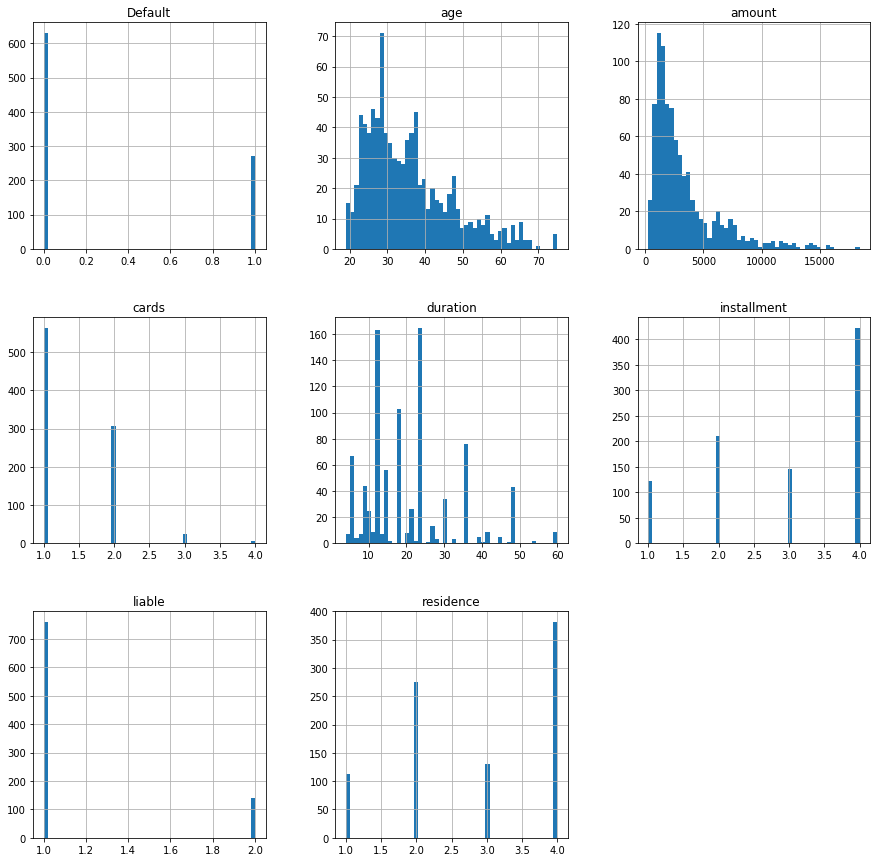

In [4]:
df.hist(bins = 50, figsize=(15,15));

In [5]:
#Checking for missing values
total = df.isnull().sum().sort_values(ascending=False)
percent_1 = df.isnull().sum()/df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(6)

,Total,%
foreign,0,0.0
status,0,0.0
checkingstatus1,0,0.0
duration,0,0.0
history,0,0.0
purpose,0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 21 columns):
Default            900 non-null int64
checkingstatus1    900 non-null object
duration           900 non-null int64
history            900 non-null object
purpose            900 non-null object
amount             900 non-null int64
savings            900 non-null object
employ             900 non-null object
installment        900 non-null int64
status             900 non-null object
others             900 non-null object
residence          900 non-null int64
property           900 non-null object
age                900 non-null int64
otherplans         900 non-null object
housing            900 non-null object
cards              900 non-null int64
job                900 non-null object
liable             900 non-null int64
tele               900 non-null object
foreign            900 non-null object
dtypes: int64(8), object(13)
memory usage: 147.8+ KB


In [7]:
cols=df.columns.to_list()
dummy=[]
other_cols=[]
for i in cols:
    if df[i].dtype == "object":
        dummy.append(i)
    else:
        other_cols.append(i)

Preprocessing

In [8]:
#Dummifying columns, dropping the original and the first dummy
data=pd.get_dummies(df, columns=["checkingstatus1","history","purpose","savings","employ",\
                                 "installment","status","others","residence","property","otherplans",\
                                "housing","cards","job","liable","tele","foreign"], drop_first=True)

In [9]:
#Normalizing columns
#Setting columns to normalize
to_normalize=["duration","amount","age"]
#For loop to normalize by min-max values
for i in to_normalize:
    x = data[[i]].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    data[i]=x_scaled

In [10]:
#Checking Data
for i in data.columns:
    print ("---- %s ---" % i)
    print (data[i].value_counts())

---- Default ---
0    630
1    270
Name: Default, dtype: int64
---- duration ---
0.357143    165
0.142857    163
0.250000    103
0.571429     76
0.035714     67
0.196429     56
0.089286     44
0.785714     43
0.464286     34
0.303571     26
0.107143     25
0.410714     13
0.125000      9
0.678571      9
1.000000      9
0.285714      8
0.071429      7
0.000000      6
0.732143      5
0.625000      5
0.160714      4
0.053571      4
0.178571      3
0.428571      3
0.517857      3
0.892857      2
0.321429      2
0.214286      2
0.767857      1
0.642857      1
0.392857      1
0.017857      1
Name: duration, dtype: int64
---- amount ---
0.055464    3
0.055684    3
0.026246    2
0.068945    2
0.060196    2
           ..
0.193023    1
0.038572    1
0.043579    1
0.399527    1
0.000000    1
Name: amount, Length: 836, dtype: int64
---- age ---
0.125000    46
0.071429    44
0.142857    43
0.089286    41
0.160714    38
0.303571    38
0.196429    38
0.107143    38
0.285714    36
0.214286    35
0.178

In [11]:
data.shape

(900, 55)

Modeling

In [12]:
# Splitting Train and Test Set
X=data.drop(["Default"], axis=1)
y=data["Default"]
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33,random_state=42)

### Model 1
#### Logistic Regression

In [13]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)#[features_sig]
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.427983
         Iterations 7
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.312     
Dependent Variable:   Default          AIC:              624.1469  
Date:                 2020-02-27 11:36 BIC:              861.8504  
No. Observations:     603              Log-Likelihood:   -258.07   
Df Model:             53               LL-Null:          -374.96   
Df Residuals:         549              LLR p-value:      1.4971e-24
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       7.0000                                       
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
duration             1.1993   0.7109  1.6869 0.0916 -0.1941  2.5927
amount               3.9437   1.0948  3.6

In [15]:
#Selecting significant features
features_sig=[]
for A, B in zip(X.columns.to_numpy(), result.pvalues.tolist()):
    if B < 0.05:
        features_sig.append(A)

In [16]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train[features_sig])#[features_sig]
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.493204
         Iterations 7
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.207     
Dependent Variable:   Default          AIC:              620.8043  
Date:                 2020-02-27 11:36 BIC:              678.0292  
No. Observations:     603              Log-Likelihood:   -297.40   
Df Model:             12               LL-Null:          -374.96   
Df Residuals:         590              LLR p-value:      5.1953e-27
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       7.0000                                       
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
amount               3.5270   0.7142  4.9387 0.0000  2.1273  4.9268
checkingstatus1_A13 -1.6441   0.5162 -3.1

In [17]:
logmodel=LogisticRegression()
logmodel.fit(X_train,y_train)#[features_sig]
predictions = logmodel.predict(X_test)#[features_sig] #use predict_proba to change cutoff

In [86]:
#Only if adjustment is needed
# adj=predictions[:,0].tolist()
# cut=[]
# k=0.7
# for i in range(len(adj)):
#     if adj[i]>k:
#         cut.append(1)
#     else:
#         cut.append(0)

In [18]:
#Coefficients of Logistic Regression
features_log = {}
lg=logmodel.coef_.tolist()
lg=lg[0]
for A, B in zip(X.columns.to_numpy(), lg):#[features_sig]
    features_log[A] = B
features_log={k: round(v,3) for k, v in sorted(features_log.items(), key=lambda item: item[1],reverse=True)}
features_log

{'amount': 1.964,
 'duration': 1.269,
 'property_A124': 0.839,
 'residence_2': 0.595,
 'purpose_A46': 0.532,
 'installment_4': 0.48,
 'property_A123': 0.437,
 'job_A173': 0.43,
 'employ_A72': 0.42,
 'others_A102': 0.412,
 'history_A31': 0.377,
 'residence_3': 0.367,
 'property_A122': 0.339,
 'cards_2': 0.333,
 'otherplans_A142': 0.253,
 'residence_4': 0.251,
 'cards_3': 0.233,
 'job_A174': 0.221,
 'employ_A73': 0.136,
 'job_A172': 0.108,
 'liable_2': 0.068,
 'employ_A75': 0.058,
 'installment_3': -0.004,
 'purpose_A45': -0.013,
 'purpose_A49': -0.02,
 'installment_2': -0.024,
 'cards_4': -0.118,
 'purpose_A42': -0.185,
 'savings_A62': -0.233,
 'history_A32': -0.306,
 'checkingstatus1_A12': -0.319,
 'status_A94': -0.339,
 'purpose_A410': -0.366,
 'employ_A74': -0.405,
 'housing_A152': -0.416,
 'purpose_A43': -0.457,
 'status_A92': -0.461,
 'housing_A153': -0.464,
 'savings_A64': -0.504,
 'otherplans_A143': -0.533,
 'others_A103': -0.536,
 'tele_A192': -0.542,
 'age': -0.608,
 'purpose_A

In [19]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       216
           1       0.61      0.53      0.57        81

    accuracy                           0.78       297
   macro avg       0.72      0.70      0.71       297
weighted avg       0.77      0.78      0.78       297



In [20]:
confusion_matrix(predictions,y_test)

array([[189,  38],
       [ 27,  43]])

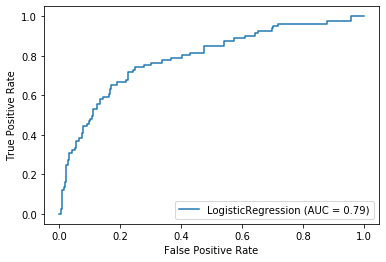

In [21]:
lr_disp = plot_roc_curve(logmodel, X_test, y_test)#[features_sig]
plt.show()

### Model 2
#### Random Forest

In [22]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)
randforest=rf.predict(X_test)

In [23]:
# Get features importance for Random Forest
features_rf = {}
for A, B in zip(X.columns.to_numpy(), rf.feature_importances_):
    features_rf[A] = B
features_rf={k: round(v,3) for k, v in sorted(features_rf.items(), key=lambda item: item[1],reverse=True)}
features_rf

{'amount': 0.12,
 'age': 0.092,
 'duration': 0.086,
 'checkingstatus1_A14': 0.058,
 'history_A34': 0.023,
 'otherplans_A143': 0.022,
 'installment_4': 0.021,
 'tele_A192': 0.021,
 'checkingstatus1_A12': 0.02,
 'savings_A65': 0.019,
 'history_A31': 0.019,
 'housing_A152': 0.019,
 'property_A123': 0.019,
 'employ_A72': 0.018,
 'status_A93': 0.018,
 'residence_2': 0.018,
 'history_A32': 0.017,
 'purpose_A43': 0.017,
 'cards_2': 0.017,
 'installment_2': 0.017,
 'job_A173': 0.017,
 'status_A92': 0.017,
 'residence_4': 0.016,
 'employ_A73': 0.016,
 'employ_A75': 0.015,
 'property_A124': 0.015,
 'property_A122': 0.014,
 'purpose_A42': 0.014,
 'purpose_A49': 0.013,
 'installment_3': 0.013,
 'job_A172': 0.013,
 'employ_A74': 0.013,
 'job_A174': 0.012,
 'liable_2': 0.012,
 'savings_A62': 0.012,
 'purpose_A41': 0.011,
 'purpose_A46': 0.011,
 'residence_3': 0.01,
 'history_A33': 0.01,
 'others_A103': 0.01,
 'checkingstatus1_A13': 0.009,
 'status_A94': 0.009,
 'others_A102': 0.009,
 'savings_A63': 

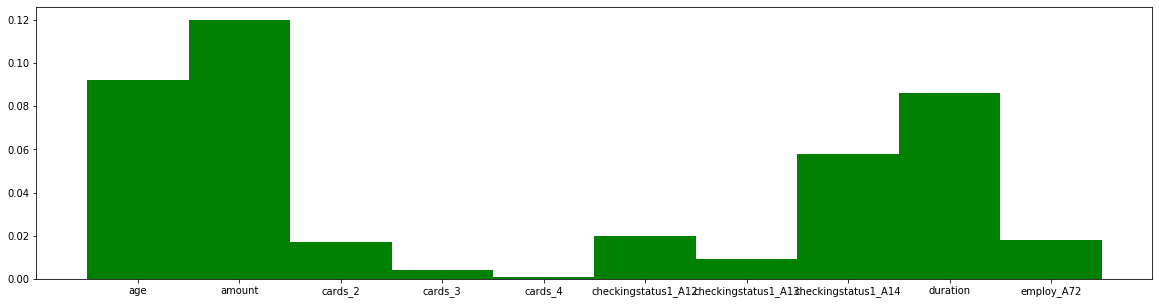

In [24]:
top10 = {k: features_rf[k] for k in sorted(features_rf.keys())[:10]}
width=1
plt.figure(figsize=(20,5))
plt.bar(top10.keys(), top10.values(), width, color='g')
plt.show()

In [25]:
print(classification_report(y_test,randforest))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       216
           1       0.65      0.46      0.54        81

    accuracy                           0.78       297
   macro avg       0.73      0.68      0.70       297
weighted avg       0.77      0.78      0.77       297



In [26]:
confusion_matrix(randforest,y_test)

array([[196,  44],
       [ 20,  37]])

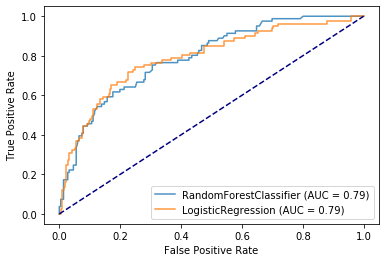

In [27]:
ax = plt.gca()
rfc_disp = plot_roc_curve(rf, X_test, y_test, ax=ax, alpha=0.8)
lr_disp.plot(ax=ax, alpha=0.8)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

### Model 3
#### KNN

In [28]:
#Setting parameters for optimal KNN
parameters = {'n_neighbors':[1,2,3,4,5,6,7],
              'leaf_size':[1,3,5],
              'algorithm':['auto', 'kd_tree'],
              'n_jobs':[-1]}

In [29]:
knngrid = KNeighborsClassifier()
neigh=GridSearchCV(knngrid, param_grid=parameters)
neigh.fit(X_train, y_train)
knn=neigh.predict(X_test)

In [30]:
neigh.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
                     weights='uniform')

In [31]:
print(classification_report(y_test,knn))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82       216
           1       0.44      0.20      0.27        81

    accuracy                           0.71       297
   macro avg       0.60      0.55      0.55       297
weighted avg       0.67      0.71      0.67       297



In [32]:
confusion_matrix(knn,y_test)

array([[196,  65],
       [ 20,  16]])

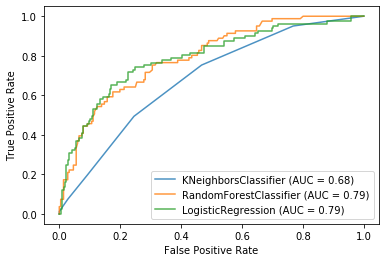

In [33]:
ax = plt.gca()
knn_disp = plot_roc_curve(neigh, X_test, y_test, ax=ax, alpha=0.8,name="KNeighborsClassifier")
rfc_disp.plot(ax=ax, alpha=0.8)
lr_disp.plot(ax=ax, alpha=0.8)
plt.show()

### Model 4
#### K-means

In [34]:
#Using only continuous variables for KMeans, which are stored in "to_normalize"
kmeans = KMeans(n_clusters=2, random_state=0).fit(X[to_normalize])

In [35]:
km=kmeans.predict(X[to_normalize])

In [36]:
gruppo=["age","duration"]

In [37]:
CLUST=X[gruppo]
CLUST=CLUST.to_numpy()

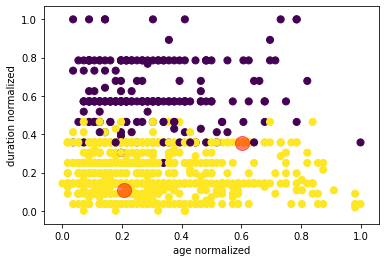

In [38]:
plt.scatter(CLUST[:, 0], CLUST[:, 1], c=km, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.xlabel("age normalized")
plt.ylabel("duration normalized")
plt.show()

In [39]:
print(classification_report(y,km))

              precision    recall  f1-score   support

           0       0.54      0.18      0.27       630
           1       0.25      0.64      0.36       270

    accuracy                           0.32       900
   macro avg       0.40      0.41      0.32       900
weighted avg       0.46      0.32      0.30       900



In [40]:
confusion_matrix(km,y)

array([[114,  96],
       [516, 174]])

In [41]:
km_fpr, km_tpr, thresholds = roc_curve(y, km)
km_auc=metrics.auc(km_fpr, km_tpr)

In [42]:
km_disp = metrics.RocCurveDisplay(fpr=km_fpr, tpr=km_tpr, roc_auc=km_auc, estimator_name='K-Means')

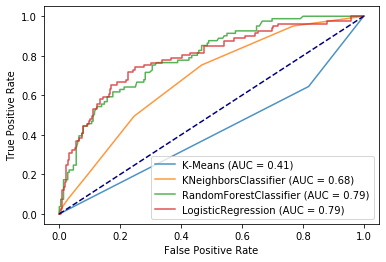

In [43]:
ax = plt.gca()
km_disp.plot(ax=ax, alpha=0.8)
knn_disp = plot_roc_curve(neigh, X_test, y_test, ax=ax, alpha=0.8,name="KNeighborsClassifier")
rfc_disp.plot(ax=ax, alpha=0.8)
lr_disp.plot(ax=ax, alpha=0.8)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

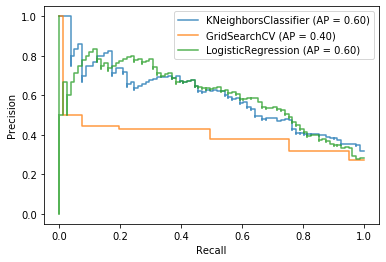

In [44]:
average_precision = average_precision_score(y_test, predictions)
ax = plt.gca()
knn_pr = plot_precision_recall_curve(rf, X_test, y_test, ax=ax, alpha=0.8,name="KNeighborsClassifier")
rf_pr = plot_precision_recall_curve(neigh, X_test, y_test, ax=ax, alpha=0.8)
lr_pr = plot_precision_recall_curve(logmodel, X_test, y_test, ax=ax, alpha=0.8)
plt.legend(loc="best")
plt.show()

### Market Basket Analysis

In [45]:
#Setting working directory
os.chdir("/Users/andreasabia/Documents/ESCP/Analytical Modeling")
#Importing dataset
mba=pd.read_csv("./data for problem B.csv")

In [46]:
# Binning
to_bin=["duration","amount","age"]
for i in to_bin:
    bins = mba[i].quantile([0,.1, .25, .5, .75]).tolist()
    labels= [0,1,2,3]
    mba[i] = pd.cut(df[i], bins=bins, labels=labels)

In [47]:
mba=pd.get_dummies(mba)

In [48]:
mba.drop(["installment","residence","cards","liable"], axis=1,inplace=True)

In [49]:
mba.shape

(900, 67)

In [50]:
#Checking Data
for i in mba.columns:
    print ("---- %s ---" % i)
    print (mba[i].value_counts())

---- Default ---
0    630
1    270
Name: Default, dtype: int64
---- checkingstatus1_A11 ---
0    649
1    251
Name: checkingstatus1_A11, dtype: int64
---- checkingstatus1_A12 ---
0    656
1    244
Name: checkingstatus1_A12, dtype: int64
---- checkingstatus1_A13 ---
0    845
1     55
Name: checkingstatus1_A13, dtype: int64
---- checkingstatus1_A14 ---
0    550
1    350
Name: checkingstatus1_A14, dtype: int64
---- duration_0 ---
0    777
1    123
Name: duration_0, dtype: int64
---- duration_1 ---
0    703
1    197
Name: duration_1, dtype: int64
---- duration_2 ---
0    732
1    168
Name: duration_2, dtype: int64
---- duration_3 ---
0    699
1    201
Name: duration_3, dtype: int64
---- history_A30 ---
0    863
1     37
Name: history_A30, dtype: int64
---- history_A31 ---
0    858
1     42
Name: history_A31, dtype: int64
---- history_A32 ---
1    475
0    425
Name: history_A32, dtype: int64
---- history_A33 ---
0    824
1     76
Name: history_A33, dtype: int64
---- history_A34 ---
0    630

In [51]:
rulezz = apriori(mba, min_support=0.05, use_colnames=True)
rulezz.sort_values('support', ascending=False)

,support,itemsets
55,0.961111,(foreign_A201)
35,0.910000,(others_A101)
630,0.880000,"(foreign_A201, others_A101)"
46,0.816667,(otherplans_A143)
706,0.782222,"(foreign_A201, otherplans_A143)"
...,...,...
3512,0.050000,"(foreign_A201, otherplans_A143, employ_A75, ch..."
8865,0.050000,"(housing_A152, history_A34, status_A93, otherp..."
570,0.050000,"(foreign_A201, status_A91)"
569,0.050000,"(others_A101, status_A91)"


In [52]:
rules = association_rules(rulezz, metric="confidence", min_threshold=0.6)
rules.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
30431,"(others_A101, employ_A75, property_A124)","(foreign_A201, housing_A153)",0.064444,0.104444,0.050000,0.775862,7.428467,0.043269,3.995556
30426,"(foreign_A201, others_A101, employ_A75, proper...",(housing_A153),0.064444,0.104444,0.050000,0.775862,7.428467,0.043269,3.995556
13022,"(others_A101, employ_A75, property_A124)",(housing_A153),0.064444,0.104444,0.050000,0.775862,7.428467,0.043269,3.995556
13024,"(employ_A75, property_A124)","(others_A101, housing_A153)",0.067778,0.100000,0.050000,0.737705,7.377049,0.043222,3.431250
30433,"(employ_A75, property_A124)","(foreign_A201, others_A101, housing_A153)",0.067778,0.100000,0.050000,0.737705,7.377049,0.043222,3.431250
...,...,...,...,...,...,...,...,...,...
4836,"(foreign_A201, purpose_A43, checkingstatus1_A12)",(others_A101),0.073333,0.910000,0.051111,0.696970,0.765901,-0.015622,0.297000
25058,"(foreign_A201, property_A121, purpose_A43, sav...",(others_A101),0.072222,0.910000,0.050000,0.692308,0.760778,-0.015722,0.292500
635,"(purpose_A43, checkingstatus1_A12)",(others_A101),0.075556,0.910000,0.052222,0.691176,0.759535,-0.016533,0.291429
9677,"(purpose_A43, property_A121, savings_A61)",(others_A101),0.075556,0.910000,0.052222,0.691176,0.759535,-0.016533,0.291429


In [53]:
a= list(rules.consequents)
a= [list(i) for i in a]
rules.consequents=a
lst=[]
for i in rules.consequents:
    if i == ['Default']:
        lst.append(True)
    else:
        lst.append(False)
rules['S']=lst

In [54]:
#Top rules which lead to default
parameter1 = rules[(rules['S']== True) & (rules['lift']>0)]
parameter1.sort_values('confidence', ascending=False).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,S
33315,"(checkingstatus1_A11, foreign_A201, others_A10...",[Default],0.113333,0.3,0.075556,0.666667,2.222222,0.041556,2.100000,True
15296,"(job_A173, others_A101, savings_A61, checkings...",[Default],0.115556,0.3,0.075556,0.653846,2.179487,0.040889,2.022222,True
45957,"(checkingstatus1_A11, foreign_A201, others_A10...",[Default],0.088889,0.3,0.057778,0.650000,2.166667,0.031111,2.000000,True
33270,"(checkingstatus1_A11, others_A101, savings_A61...",[Default],0.091111,0.3,0.057778,0.634146,2.113821,0.030444,1.913333,True
33229,"(history_A32, checkingstatus1_A11, foreign_A20...",[Default],0.084444,0.3,0.053333,0.631579,2.105263,0.028000,1.900000,True
